In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [2]:
#loads data from file into a DataFrame
def getData(filename):
    outputPandaFrame = pd.read_csv(filename)
    return outputPandaFrame

#initial data formatting
def replaceUwithNaN(inputPandaDataFrame):
    #replace all Us and Xs with NaNs because the data is unknown or unavailable
    tempdf=inputPandaDataFrame.replace('U', np.nan)
    tempdf=tempdf.replace('UU', np.nan)
    tempdf=tempdf.replace('UUU', np.nan)
    tempdf=tempdf.replace('UUUU', np.nan)
    tempdf=tempdf.replace('X', np.nan)
    tempdf=tempdf.replace('XX', np.nan)
    #the following replaces Qs and Ns with np.nan since it's technically a choice OTHER than what's in the available
    #choices in the data schema or is an irrelevant choice
    #np.nan because these data will ultimately be dropped
    tempdf=tempdf.replace('N', np.nan)
    tempdf=tempdf.replace('NN', np.nan)
    tempdf=tempdf.replace('NNNN',np.nan)
    tempdf=tempdf.replace('Q', np.nan)
    tempdf=tempdf.replace('QQ', np.nan)
    tempdf.dropna(inplace = True)
    return tempdf

#testcode here, I used the data on the site for 2017 as a test
df = getData(r'NCDB_2017.csv')
df = replaceUwithNaN(df)
year = 2017

In [3]:
#Encode P_SEX
le_sex = LabelEncoder().fit(['F', 'M'])
df['P_SEX'] = le_sex.transform(df['P_SEX']) 

In [4]:
#Explore fatality count to have idea on distribution of data
fatality_count = df.groupby('P_ISEV').size()  # 1: No injury, 2: Injury, 3: Died immediately or within the time limit
fatality_percent = ((fatality_count/fatality_count.sum())*100).round(2)
fatality_percent

P_ISEV
1    42.77
2    56.67
3     0.56
dtype: float64

In [5]:
#Explore percent severity count
severity_count = df.groupby('C_SEV').size() # 1: collision producing at least one fatality, 2: non-fatal injury
severity_percent = ((severity_count/ severity_count.sum())*100).round(2)
severity_percent

C_SEV
1     1.39
2    98.61
dtype: float64

In [6]:
#Create new feature Vehicle_Age 
df['Vehicle_Age'] = year - df['V_YEAR'].astype(int)

In [7]:
df.drop(['C_YEAR','C_CASE', 'V_YEAR', 'C_SEV', 'P_ID', 'V_ID'],axis=1, inplace=True)
#C_YEAR has 0 variance
# C_CASE is simply a case number
#C_SEV related to P_ISEV, we'll use P_ISEV for prediction
#V_YEAR replaced with Vehicle_Age
#P_ID is person ID (numbers 1-99 description of meaning not stated,except for 99 (pedestrian), no entry = 99
#V_ID is vehicle ID (numbers 1-99 description of meaning not stated, except for 99 (parked vehicle), no entry = 99

In [8]:
#Convert datatype to integer
df = df.astype(int)

In [9]:
df.columns

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR',
       'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE', 'P_SEX', 'P_AGE', 'P_PSN',
       'P_ISEV', 'P_SAFE', 'P_USER', 'Vehicle_Age'],
      dtype='object')

In [20]:
#Rank importance of features
from sklearn.ensemble import RandomForestRegressor

#Prepare data
target= df['P_ISEV']
data = df.drop(['P_ISEV'], axis =1)
features = ['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR',
       'C_RSUR', 'C_RALN', 'C_TRAF', 'V_TYPE', 'P_SEX', 'P_AGE', 'P_PSN', 'P_SAFE', 'P_USER', 'Vehicle_Age']

#Feature importance
def rankfeatures(data, features):
    rf = RandomForestRegressor()
    rf.fit(data, target)
    print("Features sorted by their score:")
    features = pd.DataFrame((sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), features), 
             reverse=True)), columns =  ['Score','Feature'])
    print(features)

rankfeatures(data, features)

Features sorted by their score:
     Score      Feature
0   0.1863        P_AGE
1   0.1391  Vehicle_Age
2   0.1282       C_HOUR
3   0.1059       C_MNTH
4   0.0814       C_WDAY
5   0.0772       C_CONF
6   0.0384       C_TRAF
7   0.0315       C_RALN
8   0.0298       C_WTHR
9   0.0296        P_PSN
10  0.0277       P_USER
11  0.0267       C_RSUR
12  0.0253        P_SEX
13  0.0231       C_VEHS
14  0.0220       C_RCFG
15  0.0139       P_SAFE
16  0.0138       V_TYPE


In [21]:
df.shape

(165646, 18)

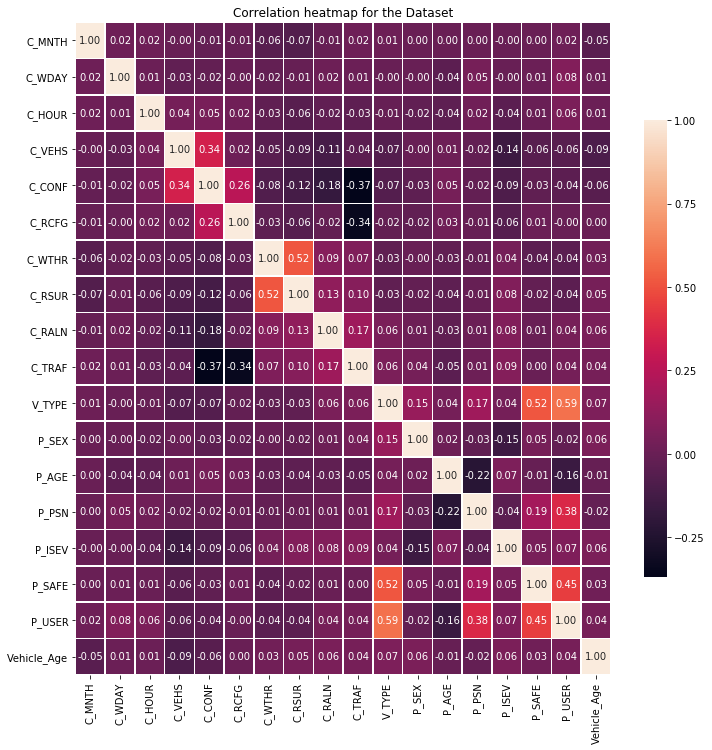

In [22]:
#Check for correlation between features
corr = df.corr()
def correlation_heatmap(corr):
    fig, ax = plt.subplots(figsize=(12, 12))   
    sns.heatmap(corr, linewidth = 0.5, fmt = '0.2f', linewidths=.5, annot=True, cbar_kws={"shrink": .70})
    plt.title('Correlation heatmap for the Dataset')
    plt.show();
    
correlation_heatmap(corr)   

In [23]:
# Select only columns which meet the threshold
corr = df.corr()
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.5:
            if columns[j]:
                columns[j] = False
            
selected_columns = df.columns[columns]
df_corr = df[selected_columns]

In [24]:
print("Features dropped based on correlation > threshold: ")
for i in range(len(df.columns)):
    if df.columns[i] not in df_corr.columns:
        print( df.columns[i])

Features dropped based on correlation > threshold: 
C_RSUR
P_SAFE
P_USER


In [25]:
df_corr.shape

(165646, 15)

In [26]:
df_ML = df_corr
#df_ML.to_csv('df2017_cleaned.csv') # uncomment to create csv file

In [27]:
df_ML.columns

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_VEHS', 'C_CONF', 'C_RCFG', 'C_WTHR',
       'C_RALN', 'C_TRAF', 'V_TYPE', 'P_SEX', 'P_AGE', 'P_PSN', 'P_ISEV',
       'Vehicle_Age'],
      dtype='object')

In [28]:
df_ML.shape

(165646, 15)